# Policy Based Method

In this exercise we want to explore policy-based methods and develop a simple hill-climbing approach to solve a reinforcement learning problem.

In order to develop the algorithm, we need:
* a function approximation (neural network) to calculate the _policy_ from the observation,
* to sample episodes and calculate the returns (or a similar measure), and
* change the network weights using noise



In [1]:
!pip install jdc
import numpy as np
import gymnasium as gym
import torch

import matplotlib
import matplotlib.pyplot as plt
import pyglet
import ipywidgets
from IPython import display

import jdc


## Build the model for the policy 

Our agent will again use a function to generate the neural network (the model), so that we can call it using different models. For torch we will define this as class that encapsulates the network for the policy (so derived from `nn.Module` and uses a method act to calculate the action which can then be used directly in the agent.


In [2]:
# Define the policy network
class PolicyNetwork(torch.nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()

        # define a function self.fc that contains the network using nn.Sequential
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(observation_space.shape[0], 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, action_space.n),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

    def act(self, obs):
        # calculate the action and return it
        obs_tensor = torch.from_numpy(obs).float().unsqueeze(0)
        action_probs = self.forward(obs_tensor)
        action = torch.multinomial(action_probs, 1).item()
        return action



In [3]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode='rgb_array')
policy = PolicyNetwork(env.observation_space, env.action_space)
obs_sample = env.observation_space.sample()
action = policy.act(obs_sample)
print(action)
action_prob = policy.forward(torch.from_numpy(obs_sample).float().unsqueeze(0))
print(action_prob)
assert action == 0 or action == 1

1
tensor([[0.4325, 0.5675]], grad_fn=<SoftmaxBackward0>)


## Agent class

Now we are ready to implement the agent class. We will start with the class definition and the `__init__` method Check the parameters and the descriptions as they will be used in the implementation.

We have two attributes in the class that save the best weights and the corresponding best return.


In [4]:
class HillClimbingAgent:
    """
    Implementation of a hill climbing reinforcement learning agent.

    The weights of the neural networks are perturbed randomly using noise, if the returns are larger, the new weights
    are kept if not the old weights are restored.

    The noise of the random changes are diminished if the agent got better and increased if not
    """
    def __init__(self, observation_space, action_space,
                 gamma: float = 0.99):
        """
        Initialize agent
        Args:
            observation_space: the observation space of the environment
            action_space: the action space of the environment
            gamma: the discount factor
        """
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma

        # additional hyperparameters
        self.min_noise_scale = 0.001
        self.max_noise_scale = 2.0

        # noise scaling
        self.noise_scale = 1.0
        
        # generate the model
        self.policy = PolicyNetwork(env.observation_space, env.action_space)

        # array to store the rewards for calculating the return
        self.rewards = []

        # array to store the weights of the model
        self.best_weights = [param.data for param in self.policy.parameters()]
        self.best_return = -np.inf

### Action

Next we implement the calculation of the action. In torch we just have to call the appropriate method from the policy.

In [5]:
%%add_to HillClimbingAgent

def calculate_action(self, obs):
    """
    Calculate the action to take
    Args:
        obs: the observation
    Returns:
        the action to take
    """
    return self.policy.act(obs)

In [6]:
obs_sample = env.observation_space.sample()
agent = HillClimbingAgent(observation_space=env.observation_space, 
                          action_space=env.action_space)

action = agent.calculate_action(obs_sample)
assert action == 0 or action == 1

### Step functions and training

Next we will add the step functions and the _training_ inside them. 

Simular to MC methods, updates only occur at the end of episodes. For the update, you have to check if the return is better than the best return so far. If yes the new weights are stored as best weights, if not, the previous best weights are restored.

The current set of weights is then changed by adding random, normally distributed noise which is multiplied by the current noise scale value.

This value should be divided by a factor of 2 if the return was better, or multiplied by a factor of 2 if the return was not. The noise should not exceed `self.max_noise_scale` or become smaller than `self.min_noise_scale`.

In [7]:
%%add_to HillClimbingAgent
def step_first(self, obs):
    """
    Calculate the action for the first step in the environment after a reset.
    Args:
        obs: The observation from the environment
    Returns:
        the action
    """
    action = self.calculate_action(obs)
    return action

def step(self, obs, reward: float, done: bool):

    # simular to MC learning, we only update at the end of an episode

    # append the reward from the last time step
    self.rewards.append(reward)

    if not done:
        # we have to do the same as in the first_step: calculate the action
        return self.step_first(obs)

    else:
        # an episode is finished, so we can calculate the return and update the weights
        current_return = sum([self.gamma ** i * reward for i, reward in enumerate(self.rewards)])
        
        # Check if current return is better than best return
        if current_return > self.best_return:
            # Update best return and save current weights as best weights
            self.best_return = current_return
            self.best_weights = [param.data.clone() for param in self.policy.parameters()]
            # Reduce noise scale (we're doing well, make smaller changes)
            self.noise_scale = max(self.noise_scale / 2.0, self.min_noise_scale)
        else:
            # Restore previous best weights (current weights didn't improve)
            for param, best_weight in zip(self.policy.parameters(), self.best_weights):
                param.data = best_weight.clone()
            # Increase noise scale (we need to explore more)
            self.noise_scale = min(self.noise_scale * 2.0, self.max_noise_scale)
        
        # Add random noise to the weights for next episode
        for param in self.policy.parameters():
            noise = torch.randn_like(param.data) * self.noise_scale
            param.data.add_(noise)

        # reset the rewards
        del self.rewards[:]

        # return None, as there is no action from a terminal state
        return None

In [8]:
env = gym.make(environment_name)
eval_env = gym.make(environment_name)

obs, info = env.reset()
np.random.seed(0)

hill_climbing_agent = HillClimbingAgent(env.observation_space, 
                                        env.action_space,
                                        gamma=0.99)

# Check if one complete episode runs through
obs, _ = env.reset()
action = hill_climbing_agent.step_first(obs)
done = False
truncated = False
while not done and not truncated:
    obs, reward, done, truncated, _ = env.step(action)
    action = hill_climbing_agent.step(obs, reward, done)


### Training and evaluation

We add the train and evaluate methods in the agents, similar to the last exercise so that it is easier to run some tests. Nothing to code here. Note that the number of steps for training are episodes here, as we only change the weights at the end of episodes

In [9]:
%%add_to HillClimbingAgent
def train(self, env: gym.Env, 
          nr_episodes_train: int, 
          eval_env: gym.Env, 
          eval_frequency: int, 
          eval_nr_episodes: int,
          eval_gamma: float = 1.0):
    """
    Train the agent on the given environment for the given number of episodes.
    Args:
        env: The environment on which to train the agent
        nr_episodes_train: the number of episodes to train
        eval_env: the environment to use for evaluation
        eval_frequency: Frequency of evaluation of the trained agent (in episodes)
        eval_nr_episodes: The number of episodes to evaluate
    """
    nr_episodes = 0
    while True:
        obs, _ = env.reset()
        a = self.step_first(obs)
        done = False
        truncated = False
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a = self.step(obs, reward, done)

        nr_episodes += 1
        if nr_episodes % eval_frequency == 0:
            rewards = self.evaluate(eval_env, eval_nr_episodes, eval_gamma)
            print(f'Evaluation: Episode trained {nr_episodes}, mean reward: {np.mean(rewards)}')
        
        if nr_episodes > nr_episodes_train:
            return

def evaluate(self, env: gym.Env, nr_episodes: int, gamma: float = 1.0):
    """
    Evaluate the agent on the given environment for the given number of episodes.
    Args:
        env: the environment on which to evaluate the agent
        nr_episodes: the number of episodes to evaluate
        
    Returns:
        the rewards for the episodes
    """
    rewards = []
    for e in range(nr_episodes):
        obs, _ = env.reset()
        a = self.calculate_action(obs)
        done = False
        truncated = False
        episode_reward = 0
        gamma_current = gamma
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a = self.calculate_action(obs)
            episode_reward += gamma_current * reward
            gamma_current *= gamma
        rewards.append(episode_reward)
    return rewards

We train the agent for a number of steps to test

In [10]:
env = gym.make(environment_name)
eval_env = gym.make(environment_name)

obs, info = env.reset()
np.random.seed(1)

# Hyperparameters will be quite important here.
hill_climbing_agent = HillClimbingAgent(env.observation_space, 
                                        env.action_space,
                                        gamma=1.0)

hill_climbing_agent.train(env, nr_episodes_train=500, 
                          eval_env=eval_env, eval_frequency=50, eval_nr_episodes=5, eval_gamma=1.0)

# calculate return at end using evaluation
return_eval = hill_climbing_agent.evaluate(env=eval_env, nr_episodes=1, gamma=1.0)

print(f'Evaluation: {return_eval}')

# The algorithms should usually the correct solution (500) within those training episodes, but it is not guaranteed :-)

assert return_eval[0] > 100

Evaluation: Episode trained 50, mean reward: 11.0
Evaluation: Episode trained 100, mean reward: 500.0
Evaluation: Episode trained 150, mean reward: 500.0
Evaluation: Episode trained 200, mean reward: 500.0
Evaluation: Episode trained 250, mean reward: 500.0
Evaluation: Episode trained 300, mean reward: 500.0
Evaluation: Episode trained 350, mean reward: 500.0
Evaluation: Episode trained 400, mean reward: 500.0
Evaluation: Episode trained 450, mean reward: 500.0
Evaluation: Episode trained 500, mean reward: 500.0
Evaluation: [500.0]


Congratulation, you have implemented your first policy-based algorithm, lets have a look at the result.

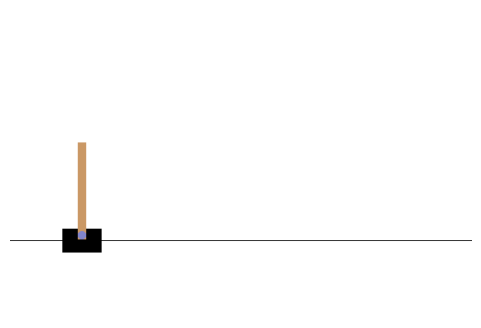

In [11]:
def display_environment(env):
    plt.figure(figsize=(6,4))
    plt.imshow(env.render())
    plt.axis('off') 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.close()

# Test the function with a few steps
env = gym.make(environment_name, render_mode='rgb_array')
obs, _ = env.reset()
for _ in range(499):
    action = hill_climbing_agent.calculate_action(obs)
    obs, _, done, _, _ = env.step(action) 
    display_environment(env)
    if done:
        obs, _ = env.reset()